In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

!pip install optuna
!pip install timm
!pip install scikit-learn
!pip install pandas
!pip install seaborn

torch version: 1.13.1
torchvision version: 0.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 5.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 22.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.7/613.7 kB 16.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 11.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 41.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 11.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━

In [2]:
# Continue with regular imports
!pip install matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary
!pip install ipython-autotime
%load_ext autotime

[INFO] Couldn't find torchinfo... installing it.
time: 752 µs (started: 2023-04-25 11:59:06 +00:00)


In [ ]:
#upload a kaggle.json file before running this code. The json file can be obtained through your account settings in kaggle
!pip install -q kaggle
!apt-get install -y unzip
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/isic-2019
!unzip /isic-2019.zip

In [4]:
import numpy as np
import pandas as pd

# read in ground truth data from a CSV file and store it in a Pandas DataFrame
groundtruth = '/ISIC_2019_Training_GroundTruth.csv'
groundtruthdf = pd.read_csv(groundtruth)

# create a new DataFrame containing column names where the value is 1 in the ground truth DataFrame
dxrow = pd.DataFrame([x for x in np.where(groundtruthdf == 1, groundtruthdf.columns,'').flatten().tolist() if len(x) > 0], columns= (["dx"]))

# read in metadata from a CSV file and store it in a Pandas DataFrame
metadata = '/ISIC_2019_Training_Metadata.csv'
metadatadf = pd.read_csv(metadata)

# merge the metadata and ground truth DataFrames on their intersection
data = pd.concat([metadatadf, dxrow], axis=1, join='inner')

# print the first few rows of the resulting DataFrame
data.head()

# print the first few rows of the ground truth DataFrame
groundtruthdf.head()

# create a dictionary mapping class names to directories containing corresponding training data
class_dict = {'MEL': 'MEL/',
              'NV': 'NV/',
              'BCC': 'BCC/',
              'AK': 'AK/',
              'BKL': 'BKL/',
              'DF': 'DF/',  
              'VASC': 'VASC/',    
              'SCC': 'SCC/'}


time: 290 ms (started: 2023-04-25 12:05:26 +00:00)


In [5]:
#this code splits the directory that contains all the images, into a 
#train/val/test split with a 80/10/10 ratio

import os
import shutil
import random

# Set the random seed for reproducibility
torch.manual_seed(42)

#define the path files
image_dir = '/ISIC_2019_Training_Input/ISIC_2019_Training_Input'
path = '/data/'
train_dir = '/data/train/'
val_dir = '/data/valid/'
test_dir = '/data/test/'

# Create the destination directories for the training, validation, and testing sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

train_set = set()
valid_set = set()
test_set = set()

for index, row in data.iterrows():
    image_file = row['image']
    class_label = row['dx']
    
    # Randomly assign 80% of the images to train set, 10% to validation set and 10% to test set. 
    rand_num = random.random()
    if rand_num < 0.8:
        dest_dir = os.path.join(train_dir, class_dict[class_label])
        train_set.add(image_file)
    elif rand_num < 0.9:
        dest_dir = os.path.join(val_dir, class_dict[class_label])
        valid_set.add(image_file)
    else:
        dest_dir = os.path.join(test_dir, class_dict[class_label])
        test_set.add(image_file)
    
    # Create the destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    # Copy the image file to the destination directory
    src_path = os.path.join(image_dir, image_file + '.jpg')
    dest_path = os.path.join(dest_dir, image_file + '.jpg')
    shutil.copy(src_path, dest_path)

 # Print class distribution for the training, validation and testing sets
print("Training Set Class Distribution:")
train_total = 0
for class_label in class_dict.values():
    class_path = os.path.join(train_dir, class_label)
    num_images = len(os.listdir(class_path))
    train_total += num_images
    print(f"{class_label}: {num_images}")
print(f"Total images in training set: {train_total}")

print("\nValidation Set Class Distribution:")
val_total = 0
for class_label in class_dict.values():
    class_path = os.path.join(val_dir, class_label)
    num_images = len(os.listdir(class_path))
    val_total += num_images
    print(f"{class_label}: {num_images}")
print(f"Total images in validation set: {val_total}")

print("\nTesting Set Class Distribution:")
test_total = 0
for class_label in class_dict.values():
    class_path = os.path.join(test_dir, class_label)
    num_images = len(os.listdir(class_path))
    test_total += num_images
    print(f"{class_label}: {num_images}")
print(f"Total images in testing set: {test_total}")


Training Set Class Distribution:
MEL/: 3639
NV/: 10296
BCC/: 2660
AK/: 698
BKL/: 2122
DF/: 185
VASC/: 205
SCC/: 493
Total images in training set: 20298

Validation Set Class Distribution:
MEL/: 405
NV/: 1322
BCC/: 319
AK/: 88
BKL/: 257
DF/: 29
VASC/: 26
SCC/: 65
Total images in validation set: 2511

Testing Set Class Distribution:
MEL/: 478
NV/: 1257
BCC/: 344
AK/: 81
BKL/: 245
DF/: 25
VASC/: 22
SCC/: 70
Total images in testing set: 2522
time: 7.06 s (started: 2023-04-25 12:05:26 +00:00)


In [6]:
# Set the random seed for reproducibility
torch.manual_seed(42)

# Get a set of pretrained model weights
weights = torchvision.models.MaxVit_T_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

# define the transform function that will be used in imagefolder to preprocess the data for MaxViT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

time: 5.01 ms (started: 2023-04-25 12:05:33 +00:00)


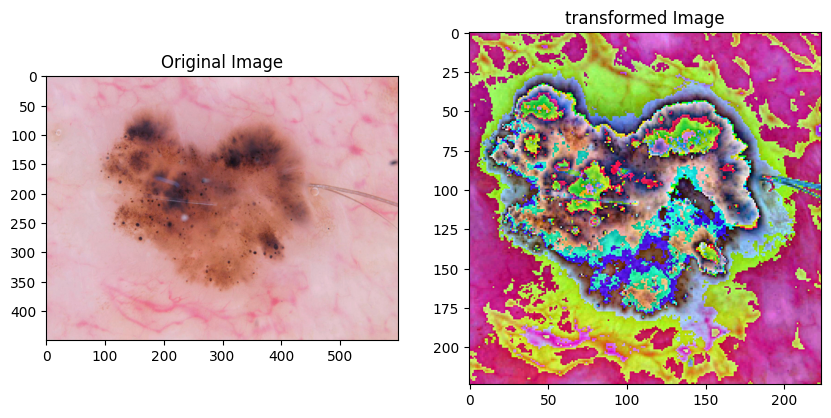

time: 897 ms (started: 2023-04-25 12:05:33 +00:00)


In [7]:
#show the image after applying transform, the picture looks distorted because 
#we have applied normalization 

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the input image

image_path = 'data/train/BCC/ISIC_0027229.jpg'
input_image = Image.open(image_path)

# Apply the transforms function to the input image
auto_transformsimg = auto_transforms(input_image)

# Convert the tensor back to an image for visualization
auto_transformsimg = transforms.ToPILImage()(auto_transformsimg)

# Display the original and transformed images side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(input_image)
axs[0].set_title('Original Image')
axs[1].imshow(auto_transformsimg)
axs[1].set_title('transformed Image')
plt.show()

In [8]:
# loading and transforming the data

!pip install torchsampler
from torchvision import datasets, transforms
import torch.utils.data as data
from torch.utils.data import Subset
from torchsampler import ImbalancedDatasetSampler

# Set the random seed for reproducibility
torch.manual_seed(42)

# Load and transform the data
train_dataset = datasets.ImageFolder(root='data/train', transform=auto_transforms)
test_dataset = datasets.ImageFolder(root='data/test', transform=auto_transforms)
val_dataset = datasets.ImageFolder(root='data/valid', transform=auto_transforms)

# load the data and shuffle the training data
train_dataloader = data.DataLoader(train_dataset, batch_size=32, sampler=ImbalancedDatasetSampler(train_dataset),pin_memory=True, num_workers=4)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False,pin_memory=True, num_workers=4)

time: 2.11 s (started: 2023-04-25 12:05:34 +00:00)


In [9]:
import timm 
#look up all the maxvit models in timm's library
maxvit_models = timm.list_models('*maxvit*')
maxvit_models

['maxvit_base_224',
 'maxvit_large_224',
 'maxvit_nano_rw_256',
 'maxvit_pico_rw_256',
 'maxvit_rmlp_nano_rw_256',
 'maxvit_rmlp_pico_rw_256',
 'maxvit_rmlp_small_rw_224',
 'maxvit_rmlp_small_rw_256',
 'maxvit_rmlp_tiny_rw_256',
 'maxvit_small_224',
 'maxvit_tiny_224',
 'maxvit_tiny_pm_256',
 'maxvit_tiny_rw_224',
 'maxvit_tiny_rw_256',
 'maxvit_xlarge_224']

time: 121 ms (started: 2023-04-25 12:05:36 +00:00)


In [ ]:
#create the maxvit model
#to create this code, timm's library has been used. 

import timm 
import torch
import torch.nn as nn

# Set the random seed for reproducibility
torch.manual_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

#create the model and change number of classes to 8
model = timm.create_model('maxvit_rmlp_small_rw_224', pretrained=True, num_classes=8)

#freeze the weights
for param in model.parameters():
    param.requires_grad = False
   
# unfreeze the last fc layer
for param in model.head.parameters():
    param.requires_grad = True
    
# Add a dropout layer to the fc sequential block in the ClassifierHead
model.head.fc = nn.Sequential(
nn.Dropout(p=0.25),
nn.Linear(model.head.fc.in_features, model.head.fc.out_features)
)

model.to(device)


In [11]:
# Print a summary using torchinfo (uncomment for actual output)

model = model
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MaxxVit (MaxxVit)                                                 [32, 3, 224, 224]    [32, 8]              --                   Partial
├─Stem (stem)                                                     [32, 3, 224, 224]    [32, 64, 112, 112]   --                   False
│    └─Conv2d (conv1)                                             [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    └─BatchNormAct2d (norm1)                                     [32, 32, 112, 112]   [32, 32, 112, 112]   64                   False
│    │    └─Identity (drop)                                       [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    │    └─SiLU (act)                                            [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Conv2d (conv2)                                  

time: 1.66 s (started: 2023-04-25 12:05:49 +00:00)


In [12]:
# define optimizers and loss function and use the best hyperparameters found during the HP tuning

# Set the random seed for reproducibility
torch.manual_seed(42)

# Setup device agnostic code
criterion = nn.CrossEntropyLoss()
optimizer =  torch.optim.AdamW(model.parameters(), lr=0.0010431796276198983)

time: 3.02 ms (started: 2023-04-25 12:05:50 +00:00)


In [13]:
#in this code we apply mixed precision training to allow for faster training and use early stopping to prevent overfitting 

# Set the random seed for reproducibility
torch.manual_seed(42)

import matplotlib.pyplot as plt
import torch
# Creates once at the beginning of training
scaler = torch.cuda.amp.GradScaler()

# Lists to store the loss and accuracy values
train_losses = []
train_accs = []
val_losses = []
val_accs = []

# Train the model
num_epochs = 20
best_val_loss = float('inf')
patience = 5
for epoch in range(num_epochs):
    # Train the model
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for data in train_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        optimizer.zero_grad()
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()    # Scale the gradients
        scaler.step(optimizer)           # Update the model parameters
        scaler.update()                  # Update the scaler
        train_loss += loss.item() * inputs.size(0)
        train_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Evaluate the model
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for data in valid_dataloader:
            inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

    # Print the results for this epoch
    train_loss /= len(train_dataloader.dataset)
    train_acc /= len(train_dataloader.dataset)
    val_loss /= len(valid_dataloader.dataset)
    val_acc /= len(valid_dataloader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Save the loss and accuracy values
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Check if the current validation loss is the best seen so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict()
        epochs_since_improvement = 0
    else:
        epochs_since_improvement += 1

    # Stop training if the validation loss has not improved for `patience` epochs
    if epochs_since_improvement == patience:
        print(f"No improvement for {patience} epochs, stopping training.")
        break

Epoch 1/20: Train Loss: 1.3850, Train Acc: 0.4968, Val Loss: 1.3434, Val Acc: 0.5133
Epoch 2/20: Train Loss: 1.1608, Train Acc: 0.5857, Val Loss: 1.2799, Val Acc: 0.5396
Epoch 3/20: Train Loss: 1.1378, Train Acc: 0.5911, Val Loss: 1.1602, Val Acc: 0.5966
Epoch 4/20: Train Loss: 1.1178, Train Acc: 0.5978, Val Loss: 1.1698, Val Acc: 0.5854
Epoch 5/20: Train Loss: 1.1048, Train Acc: 0.5960, Val Loss: 1.2328, Val Acc: 0.5627
Epoch 6/20: Train Loss: 1.1029, Train Acc: 0.5990, Val Loss: 1.1478, Val Acc: 0.5910
Epoch 7/20: Train Loss: 1.1036, Train Acc: 0.6002, Val Loss: 1.1513, Val Acc: 0.5894
Epoch 8/20: Train Loss: 1.0735, Train Acc: 0.6105, Val Loss: 1.1305, Val Acc: 0.5890
Epoch 9/20: Train Loss: 1.0932, Train Acc: 0.6054, Val Loss: 1.2613, Val Acc: 0.5488
Epoch 10/20: Train Loss: 1.0969, Train Acc: 0.6015, Val Loss: 1.1989, Val Acc: 0.5571
Epoch 11/20: Train Loss: 1.0848, Train Acc: 0.6113, Val Loss: 1.1368, Val Acc: 0.5874
Epoch 12/20: Train Loss: 1.0907, Train Acc: 0.6061, Val Loss: 1

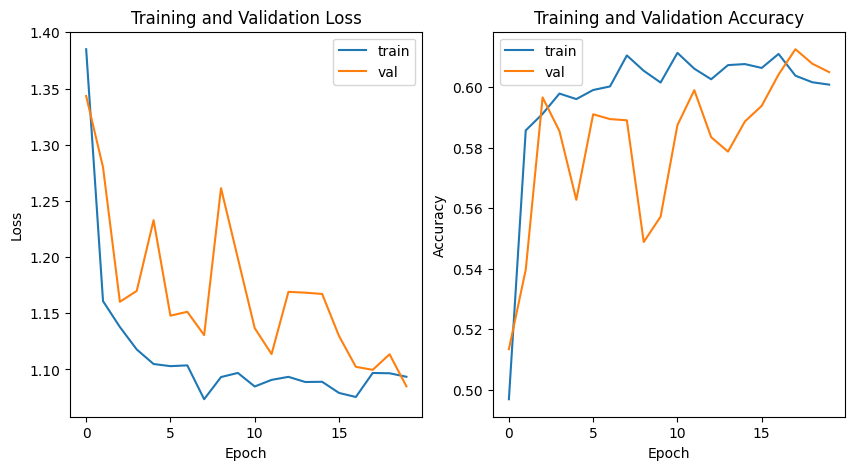

time: 259 ms (started: 2023-04-25 12:42:31 +00:00)


In [14]:
# Plot the validation and training loss and accuracy values
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(train_losses, label='train')
ax[0].plot(val_losses, label='val')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training and Validation Loss')
ax[0].legend()
ax[1].plot(train_accs, label='train')
ax[1].plot(val_accs, label='val')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Training and Validation Accuracy')
ax[1].legend()
plt.show()

In [15]:
#evaluate on test set and calculate metrics, we are calculating macro f1 and roc-auc score, because of the heavily imbalanced dataset
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, classification_report
import pandas as pd
import numpy as np

model.eval()
test_loss = 0.0
test_acc = 0.0
y_true = []
y_scores = []
y_pred = []

with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data[0].to(device), data[1].to(device) # Move data to device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        test_acc += torch.sum(torch.argmax(outputs, dim=1) == labels).item()

        # Append predictions to lists
        y_true.extend(labels.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())
        y_pred.extend(torch.argmax(outputs, dim=1).cpu().numpy())

test_loss /= len(test_dataloader.dataset)
test_acc /= len(test_dataloader.dataset)

# Calculate metrics

import warnings
from sklearn.exceptions import UndefinedMetricWarning

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
    report = classification_report(y_true, y_pred, target_names=[str(i) for i in range(8)], digits=4)

conf_mat = confusion_matrix(y_true, y_pred)
roc_auc = roc_auc_score(np.array(pd.get_dummies(y_true)), y_scores, average='macro')
f1 = f1_score(y_true, y_pred, average='weighted')

# Calculate other metrices
n_classes = conf_mat.shape[0]
sensitivity = 0
specificity = 0
for i in range(n_classes):
    tp = conf_mat[i,i]
    fn = np.sum(conf_mat[i,:]) - tp
    fp = np.sum(conf_mat[:,i]) - tp
    tn = np.sum(conf_mat) - tp - fn - fp
    sensitivity += tp / (tp + fn) * np.sum(conf_mat[i,:])
    specificity += tn / (tn + fp) * np.sum(conf_mat[i,:])
sensitivity /= np.sum(conf_mat)
specificity /= np.sum(conf_mat)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:")
print(report)

Test Loss: 1.1010
Test Accuracy: 0.5948
Sensitivity: 0.5948
Specificity: 0.8978
ROC-AUC: 0.8487
F1-score: 0.6200
Classification Report:
              precision    recall  f1-score   support

           0     0.2426    0.5062    0.3280        81
           1     0.6371    0.4593    0.5338       344
           2     0.3516    0.3918    0.3707       245
           3     0.0932    0.4400    0.1538        25
           4     0.6101    0.4289    0.5037       478
           5     0.8357    0.7486    0.7898      1257
           6     0.1802    0.4429    0.2562        70
           7     0.2125    0.7727    0.3333        22

    accuracy                         0.5948      2522
   macro avg     0.3954    0.5238    0.4087      2522
weighted avg     0.6688    0.5948    0.6200      2522

time: 1min 4s (started: 2023-04-25 12:42:32 +00:00)


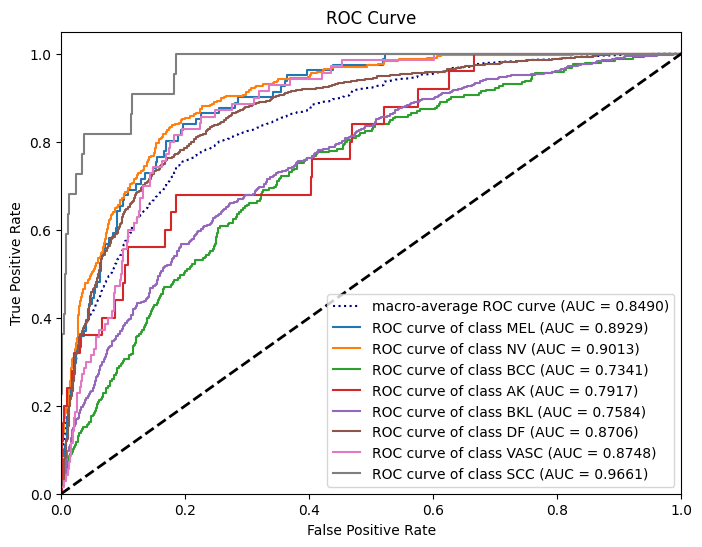

time: 194 ms (started: 2023-04-25 12:43:36 +00:00)


In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Convert the y_true and y_scores lists to arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_true))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_true == i).astype(int), y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (AUC = {0:0.4f})'.format(roc_auc["macro"]), color='navy', linestyle=':')

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (AUC = {1:0.4f})'.format(class_dict[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

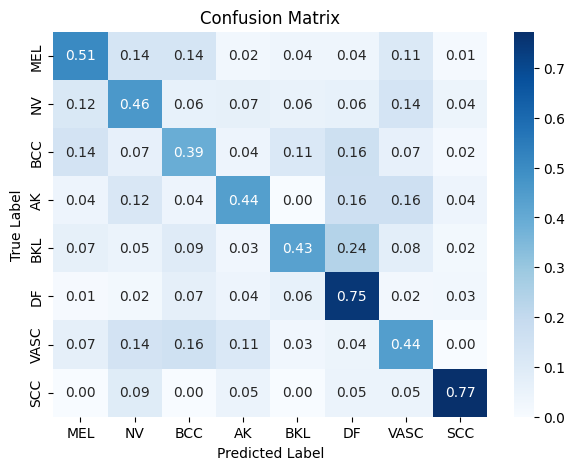

time: 385 ms (started: 2023-04-25 12:43:36 +00:00)


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a dictionary mapping class indices to class names
class_dict = {0: 'MEL', 1: 'NV', 2: 'BCC', 3: 'AK', 4: 'BKL', 5: 'DF', 6: 'VASC', 7: 'SCC'}

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(conf_mat / conf_mat.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2f', cmap=plt.cm.Blues, ax=ax)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
class_labels = sorted(list(class_dict.keys()), key=lambda x: int(x))
ax.xaxis.set_ticklabels([class_dict[label] for label in class_labels])
ax.yaxis.set_ticklabels([class_dict[label] for label in class_labels])
plt.show()